In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt

## ActiveLearningPipeline Class

In [66]:
class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 nodes_df_path,
                 subject_mapping_path):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.nodes_df_path = nodes_df_path
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        self.nodes_df = pd.read_csv(nodes_df_path)
        self.feature_vectors = self._read_feature_vectors()
        self.labels = self._read_labels(subject_mapping_path)
        self.index_dict = {id: i for i, id in enumerate(self.nodes_df['nodeId'])}
        self.train_indices = np.array([self.index_dict[id] for id in self.train_indices])
        self.test_indices = np.array([self.index_dict[id] for id in self.test_indices])
        self.available_pool_indices = np.array([self.index_dict[id] for id in self.available_pool_indices])
        self.train_labels = self.labels[self.train_indices]
        # TODO: Implement the rest of the constructor and the method run_pipeline (this method should not be called in the constructor, but from outside the class)
        self.model_object = self.choose_model(model)
        # TODO: You are allowed to add more class methods if needed, but a class method cannot be longer than 15 lines of code
        # TODO: Do not change the constructor signature and the already implemented methods

    def choose_model(self, model_name):
        """
        Choose the model to be used in the active learning pipeline
        """
        if self.model == 'RandomForest':
            return RandomForestClassifier()
        elif self.model == 'SVM':
            return SVC()
        else:
            return LogisticRegression()


    def _read_feature_vectors(self):
        """
        Read feature vectors from the nodes dataframe
        :return:
        feature_vectors: numpy array, feature vectors
        """
        feature_vectors_raw = self.nodes_df['features'].apply((lambda x: x.strip('][').split(', ')))
        return np.array([[float(val) for val in feature_vector] for feature_vector in feature_vectors_raw])

    def _read_labels(self, subject_mapping_path):
        """
        Read subjects from the nodes dataframe, and convert them to labels (integers)
        :return:
        labels: numpy array, labels
        """
        with open(subject_mapping_path, 'rb') as f:
            subject_mapping = pickle.load(f)
        labels = self.nodes_df['subject'].apply(lambda x: subject_mapping[x])
        return np.array(labels)

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        for iteration in range(self.iterations):
            print(f'Iteration {iteration + 1}/{self.iterations} started')
            if len(self.train_indices) > 600:
                # raise error if the train set is larger than 600 samples
                raise ValueError('The train set is larger than 600 samples')
            # TODO: Implement the active learning pipeline. 

            # train the model
            self.model_object.fit(self.feature_vectors[self.train_indices], self.train_labels)

            # select the samples to be added to the train set
            selected_sample_idx = self.get_samples()

            # add the selected sample to the train set
            self.train_indices = np.append(self.train_indices, selected_sample_idx)
            self.train_labels = np.append(self.train_labels, self.model_object.predict(self.feature_vectors[selected_sample_idx]))
            # remove the selected sample from the available pool
            indices_to_delete = np.where(np.isin(self.available_pool_indices, selected_sample_idx))[0]
            self.available_pool_indices = np.delete(self.available_pool_indices, indices_to_delete)


            # TODO: Do not change the lines that are already implemented here in this method. Only add your code before and after them.
            accuracy = self._evaluate_model(self.model_object)
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def _evaluate_model(self, trained_model):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        # todo: Make sure that there is no test sample in the train set
        preds = trained_model.predict(self.feature_vectors[self.test_indices])
        return round(np.mean(preds == self.labels[self.test_indices]), 3)
    
    def _random_sampling(self):
        """
        Randomly select samples from the available pool
        :return:
        selected_samples: list, indices of the selected samples
        """
        return np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
    
    def _uncertainity_sampling(self):
        """
        Select samples based on the uncertainty of the model
        :return:
        selected_samples: list, indices of the selected samples
        """
        predictions = self.model_object.predict_proba(self.feature_vectors[self.available_pool_indices])
        uncertainty_scores = np.array([entropy(prediction) for prediction in predictions])
        indices = np.argsort(uncertainty_scores)[:self.budget_per_iter]
        return self.available_pool_indices[indices]
    
    def _custom_sampling(self):
        """
        Implement your own sampling strategy
        :return:
        selected_samples: list, indices of the selected samples
        """
        # Implementing density based sampling
        # Calculate the density of each sample
        density_scores = self._compute_density()
        # Select the samples with the lowest density (least explored areas)
        selected_indices = np.argsort(density_scores)[:self.budget_per_iter]
        return selected_indices
        # # Select the samples with the highest density
        # return np.argsort(density_scores)[:self.budget_per_iter]
    
    def _compute_density(self):
        """
        Compute the density of the samples
        :return:
        density_scores: list, density scores of the samples
        """
        # Implementing density based sampling
        # Calculate the density of each sample
        # Calculate the distance between each sample and the rest of the samples
        distances = np.zeros((len(self.available_pool_indices), len(self.available_pool_indices)))
        for i, sample in enumerate(self.available_pool_indices):
            for j, other_sample in enumerate(self.available_pool_indices):
                distances[i, j] = np.linalg.norm(self.feature_vectors[sample] - self.feature_vectors[other_sample])
        # Calculate the density of each sample
        # density_scores = np.sum(distances, axis=1)
        density_scores = np.sum(np.exp(-distances), axis=1)
        return density_scores
    
    def get_samples(self):
        """
        Get the samples to be added to the train set
        :return:
        selected_samples: list, indices of the selected samples
        """
        if self.selection_criterion == 'random':
            return self._random_sampling()
        elif self.selection_criterion == 'uncertainty':
            return self._uncertainity_sampling()
        else:
            return self._custom_sampling()



In [61]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [68]:
model = 'SVC' # Choose a model ('RandomForestClassifier', 'SVC', 'LogisticRegression')
with open('data\indices_dict_part1.pkl', 'rb') as f:
    indices_dict = pickle.load(f)
available_pool_indices = indices_dict['available_pool_indices']
train_indices = indices_dict['train_indices']
test_indices = indices_dict['test_indices']
iterations = 50
budget_per_iter = 10
nodes_df_path = 'data\\nodes.csv'
subject_mapping_path = 'data\subject_mapping.pkl'

selection_criteria = ['uncertainty','random', 'custom'] # Add more criteria if needed
accuracy_scores_dict = defaultdict(list)

Iteration 1/50 started
Iteration 2/50 started
Iteration 3/50 started
Iteration 4/50 started
Iteration 5/50 started
Iteration 6/50 started
Iteration 7/50 started
Iteration 8/50 started
Iteration 9/50 started
Iteration 10/50 started
Iteration 11/50 started
Iteration 12/50 started
Iteration 13/50 started
Iteration 14/50 started
Iteration 15/50 started
Iteration 16/50 started
Iteration 17/50 started
Iteration 18/50 started
Iteration 19/50 started
Iteration 20/50 started
Iteration 21/50 started
Iteration 22/50 started
Iteration 23/50 started
Iteration 24/50 started
Iteration 25/50 started
Iteration 26/50 started
Iteration 27/50 started
Iteration 28/50 started
Iteration 29/50 started
Iteration 30/50 started
Iteration 31/50 started
Iteration 32/50 started
Iteration 33/50 started
Iteration 34/50 started
Iteration 35/50 started
Iteration 36/50 started
Iteration 37/50 started
Iteration 38/50 started
Iteration 39/50 started
Iteration 40/50 started
Iteration 41/50 started
Iteration 42/50 started
I

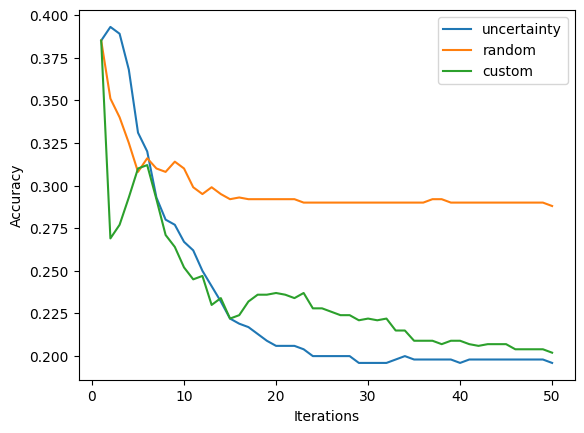

In [69]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)